<a href="https://colab.research.google.com/github/CryptoRobotFr/TrueStrategy/blob/main/Aligator_Strategy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install python-binance

In [ ]:
pip install ta

In [ ]:
pip install pandas_ta

<h1>Import Dataset</h1>

In [102]:
import pandas as pd
from binance.client import Client
import ta
import pandas_ta as pda
import matplotlib.pyplot as plt
import numpy as np
from termcolor import colored

client = Client()

klinesT = client.get_historical_klines("EGLDUSDT", Client.KLINE_INTERVAL_1HOUR, "01 january 2017")

df = pd.DataFrame(klinesT, columns = ['timestamp', 'open', 'high', 'low', 'close', 'volume', 'close_time', 'quote_av', 'trades', 'tb_base_av', 'tb_quote_av', 'ignore' ])
df['close'] = pd.to_numeric(df['close'])
df['high'] = pd.to_numeric(df['high'])
df['low'] = pd.to_numeric(df['low'])
df['open'] = pd.to_numeric(df['open'])

df = df.set_index(df['timestamp'])
df.index = pd.to_datetime(df.index, unit='ms')
del df['timestamp']
print(df)

# ----- Functions Definition -------
def get_chop(high, low, close, window):
    tr1 = pd.DataFrame(high - low).rename(columns = {0:'tr1'})
    tr2 = pd.DataFrame(abs(high - close.shift(1))).rename(columns = {0:'tr2'})
    tr3 = pd.DataFrame(abs(low - close.shift(1))).rename(columns = {0:'tr3'})
    frames = [tr1, tr2, tr3]
    tr = pd.concat(frames, axis = 1, join = 'inner').dropna().max(axis = 1)
    atr = tr.rolling(1).mean()
    highh = high.rolling(window).max()
    lowl = low.rolling(window).min()
    ci = 100 * np.log10((atr.rolling(window).sum()) / (highh - lowl)) / np.log10(window)
    return ci

                        open     high  ...       tb_quote_av  ignore
timestamp                              ...                          
2020-09-03 03:00:00   19.710   35.000  ...  3164549.34126200       0
2020-09-03 04:00:00   23.601   24.261  ...   807376.72589300       0
2020-09-03 05:00:00   22.918   25.102  ...  1141679.41341000       0
2020-09-03 06:00:00   24.178   24.300  ...   397573.56780400       0
2020-09-03 07:00:00   23.482   23.800  ...   569708.05888000       0
...                      ...      ...  ...               ...     ...
2021-08-26 10:00:00  134.850  139.890  ...   691426.05350000       0
2021-08-26 11:00:00  138.080  139.100  ...   587730.77470000       0
2021-08-26 12:00:00  136.860  139.750  ...  1340705.78790000       0
2021-08-26 13:00:00  138.580  144.240  ...  1465116.76273400       0
2021-08-26 14:00:00  143.160  144.310  ...   951433.55190000       0

[8564 rows x 11 columns]


<h1>Backtest Execution</h1>

In [103]:
df.drop(df.columns.difference(['open','high','low','close','volume']), 1, inplace=True)

#Simple Moving Average
# df['SMA']=ta.trend.sma_indicator(df['close'], window=12)

#Exponential Moving Average
df['EMA1']=ta.trend.ema_indicator(close=df['close'], window=7)
df['EMA2']=ta.trend.ema_indicator(close=df['close'], window=30)
df['EMA3']=ta.trend.ema_indicator(close=df['close'], window=50)
df['EMA4']=ta.trend.ema_indicator(close=df['close'], window=100)
df['EMA5']=ta.trend.ema_indicator(close=df['close'], window=121)
df['EMA6']=ta.trend.ema_indicator(close=df['close'], window=200)

# #Relative Strength Index (RSI)
# df['RSI'] =ta.momentum.rsi(close=df['close'], window=10)
# df['Hrsi'] =df['RSI'].rolling(18).max()
# df['Lrsi'] =df['RSI'].rolling(18).min()
# df['stoch'] = (df['RSI'] - df['Lrsi']) / (df['Hrsi'] - df['Lrsi'])
# df['stochK'] = ta.trend.sma_indicator(df['stoch'],3) * 100
# df['stochD'] = ta.trend.sma_indicator(df['stochK'],2)


# #MACD
# MACD = ta.trend.MACD(close=df['close'], window_fast=12, window_slow=26, window_sign=9)
# df['MACD'] = MACD.macd()
# df['MACD_SIGNAL'] = MACD.macd_signal()
# df['MACD_DIFF'] = MACD.macd_diff() #Histogramme MACD

# #Stochastic RSI
df['STOCH_RSI'] = ta.momentum.stochrsi(close=df['close'], window=14, smooth1=3, smooth2=3) #Non moyenné 
# df['STOCH_RSI_D'] = ta.momentum.stochrsi_d(close=df['close'], window=14, smooth1=3, smooth2=3) #Orange sur TradingView
# df['STOCH_RSI_K'] = ta.momentum.stochrsi_k(close=df['close'], window=14, smooth1=3, smooth2=3) #Bleu sur TradingView

# #Ichimoku
# df['KIJUN'] = ta.trend.ichimoku_base_line(high=df['high'], low=df['low'], window1=9, window2=26)
# df['TENKAN'] = ta.trend.ichimoku_conversion_line(high=df['high'], low=df['low'], window1=9, window2=26)
# df['SSA'] = ta.trend.ichimoku_a(high=df['high'], low=df['low'], window1=9, window2=26)
# df['SSB'] = ta.trend.ichimoku_b(high=df['high'], low=df['low'], window2=26, window3=52)

# #Bollinger Bands
# BOL_BAND = ta.volatility.BollingerBands(close=df['close'], window=20, window_dev=2)
# df['BOL_H_BAND'] = BOL_BAND.bollinger_hband() #Bande Supérieur
# df['BOL_L_BAND'] = BOL_BAND.bollinger_lband() #Bande inférieur
# df['BOL_MAVG_BAND'] = BOL_BAND.bollinger_mavg() #Bande moyenne

# #Average True Range (ATR)
df['ATR'] = ta.volatility.average_true_range(high=df['high'], low=df['low'], close=df['close'], window=14)

# #Super Trend
# ST_length = 10
# ST_multiplier = 2.0
# superTrend = pda.supertrend(high=df['high'], low=df['low'], close=df['close'], length=ST_length, multiplier=ST_multiplier)
# df['SUPER_TREND'] = superTrend['SUPERT_'+str(ST_length)+"_"+str(ST_multiplier)] #Valeur de la super trend
# df['SUPER_TREND_DIRECTION'] = superTrend['SUPERTd_'+str(ST_length)+"_"+str(ST_multiplier)] #Retourne 1 si vert et -1 si rouge

# #Awesome Oscillator
# df['AWESOME_OSCILLATOR'] = ta.momentum.awesome_oscillator(high=df['high'], low=df['low'], window1=5, window2=34)

# # Kaufman’s Adaptive Moving Average (KAMA)
# df['KAMA1'] = ta.momentum.kama(close=ta.momentum.kama(close=ta.momentum.kama(close=df['close'], window=11, pow1=2, pow2=30), window=11, pow1=2, pow2=30), window=11, pow1=2, pow2=30)
# df['KAMA2'] = ta.momentum.kama(close=df['close'], window=15, pow1=2, pow2=30)

# #Choppiness index
# df['CHOP'] = get_chop(high=df['high'], low=df['low'], close=df['close'], window=14)  


# df['PC_KAMA'] =  df["KAMA1"].pct_change()*100
# df['SMA_KAMA'] = ta.trend.sma_indicator(close=df['PC_KAMA'], window=14)
# df['HISTO_KAMA'] = df['PC_KAMA'] - df['SMA_KAMA']

df

,open,high,low,close,volume,EMA1,EMA2,EMA3,EMA4,EMA5,EMA6,STOCH_RSI,ATR
timestamp,,,,,,,,,,,,,
2020-09-03 03:00:00,19.710,35.000,19.710,23.640,230806.88500000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000
2020-09-03 04:00:00,23.601,24.261,22.150,22.920,73034.90200000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000
2020-09-03 05:00:00,22.918,25.102,22.810,24.217,85861.99100000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000
2020-09-03 06:00:00,24.178,24.300,22.919,23.484,37018.33500000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000
2020-09-03 07:00:00,23.482,23.800,20.975,22.801,58391.89900000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-08-26 10:00:00,134.850,139.890,134.510,138.030,9028.52000000,136.659990,138.054688,139.542495,142.267224,142.858249,143.151201,0.699779,3.475468
2021-08-26 11:00:00,138.080,139.100,136.850,136.850,8700.45000000,136.707493,137.976966,139.436907,142.159952,142.759753,143.088503,0.562898,3.387935
2021-08-26 12:00:00,136.860,139.750,134.250,138.450,16489.00000000,137.143120,138.007485,139.398204,142.086487,142.689101,143.042348,0.755194,3.538797


<h1>Spot Backtest</h1>

Period : [2020-09-03 03:00:00] -> [2021-08-26 14:00:00]
Starting balance : 1000 $
Final balance : 14458.85 $
Performance vs US Dollar : 1345.88 %
Buy and Hold Performence : 500.25 %
Performance vs Buy and Hold : 169.04 %
Number of negative trades :  10
Number of positive trades :  7
Average Positive Trades :  73.7 %
Average Negative Trades :  -3.76 %
Best trade +227.67 %, the  2021-02-15 03:00:00
Worst trade -6.58 %, the  2021-03-31 09:00:00
Worst drawBack -13.0 %
Total fee :  144.09 $
Buy Market number : 17
Sell Market number : 17
PLOT


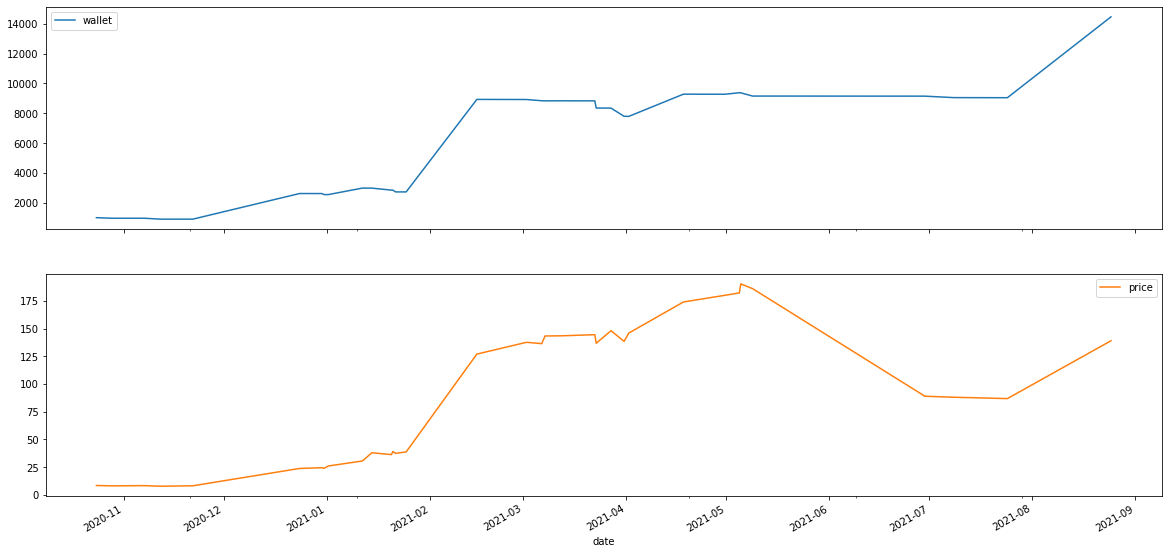

In [104]:
dfTest = df.copy()
# dfTest = df['2021-01-01':]
dt = None
dt = pd.DataFrame(columns = ['date','position', 'reason', 'price', 'frais' ,'fiat', 'coins', 'wallet', 'drawBack'])

usdt = 1000
initalWallet = usdt
coin = 0
wallet = 1000
lastAth = 0
previousRow = dfTest.iloc[0]
makerFee = 0.0003
takerFee = 0.0007
stopLoss = 0
takeProfit = 500000
buyReady = True
sellReady = True

def buyCondition(row, previousRow):
  if row['EMA1'] > row['EMA2'] and row['EMA2'] > row['EMA3'] and row['EMA3'] > row['EMA4'] and row['EMA4'] > row['EMA5'] and row['EMA5'] > row['EMA6'] and row['STOCH_RSI']<0.82:
    return True
  else:
    return False

  
def sellCondition(row, previousRow):
  if row['EMA6'] > row['EMA1'] and row['STOCH_RSI']>0.2:
    return True
  else:
    return False


for index, row in dfTest.iterrows():
  #Buy market order
  if buyCondition(row, previousRow) == True and usdt > 0 and buyReady == True:
    #You can define here at what price you buy
    buyPrice = row['close']

    #Define the price of you SL and TP or comment it if you don't want a SL or TP
    # stopLoss = buyPrice - 2 * row['ATR']
    # takeProfit = buyPrice + 4 * row['ATR']

    coin = usdt / buyPrice
    fee = takerFee * coin
    coin = coin - fee
    usdt = 0
    wallet = coin * row['close']
    if wallet > lastAth:
      lastAth = wallet

    # print("Buy COIN at",buyPrice,'$ the', index)
    myrow = {'date': index,'position': "Buy", 'reason': 'Buy Market','price': buyPrice,'frais': fee*row['close'],'fiat': usdt,'coins': coin,'wallet': wallet,'drawBack':(wallet-lastAth)/lastAth}
    dt = dt.append(myrow,ignore_index=True)
  
  #Stop Loss
  elif row['low'] < stopLoss and coin > 0:

    sellPrice = stopLoss

    usdt = coin * sellPrice
    fee = makerFee * usdt
    usdt = usdt - fee
    coin = 0
    buyReady = False
    wallet = usdt
    if wallet > lastAth:
      lastAth = wallet
    # print("Sell COIN at Stop Loss",sellPrice,'$ the', index)
    myrow = {'date': index,'position': "Sell", 'reason': 'Sell Stop Loss', 'price': sellPrice, 'frais': fee, 'fiat': usdt, 'coins': coin, 'wallet': wallet, 'drawBack':(wallet-lastAth)/lastAth}
    dt = dt.append(myrow,ignore_index=True)

  #Take Profit
  elif row['high'] > takeProfit and coin > 0:

    sellPrice = takeProfit

    usdt = coin * sellPrice
    fee = makerFee * usdt
    usdt = usdt - fee
    coin = 0
    buyReady = False
    wallet = usdt
    if wallet > lastAth:
      lastAth = wallet
    # print("Sell COIN at Take Profit Loss",sellPrice,'$ the', index)
    myrow = {'date': index,'position': "Sell", 'reason': 'Sell Take Profit', 'price': sellPrice, 'frais': fee, 'fiat': usdt, 'coins': coin, 'wallet': wallet, 'drawBack':(wallet-lastAth)/lastAth}
    dt = dt.append(myrow,ignore_index=True)     

  # Sell Market
  elif sellCondition(row, previousRow) == True:
    buyReady = True
    if coin > 0 and sellReady == True:
      sellPrice = row['close']
      usdt = coin * sellPrice
      frais = takerFee * usdt
      usdt = usdt - frais
      coin = 0
      wallet = usdt
      if wallet > lastAth:
        lastAth = wallet
      # print("Sell COIN at",sellPrice,'$ the', index)
      myrow = {'date': index,'position': "Sell", 'reason': 'Sell Market', 'price': sellPrice, 'frais': frais, 'fiat': usdt, 'coins': coin, 'wallet': wallet, 'drawBack':(wallet-lastAth)/lastAth}
      dt = dt.append(myrow,ignore_index=True)
  
  previousRow = row

#///////////////////////////////////////
print("Period : [" + str(dfTest.index[0]) + "] -> [" +str(dfTest.index[len(dfTest)-1]) + "]")
dt = dt.set_index(dt['date'])
dt.index = pd.to_datetime(dt.index)
dt['resultat'] = dt['wallet'].diff()
dt['resultat%'] = dt['wallet'].pct_change()*100
dt.loc[dt['position']=='Buy','resultat'] = None
dt.loc[dt['position']=='Buy','resultat%'] = None

dt['tradeIs'] = ''
dt.loc[dt['resultat']>0,'tradeIs'] = 'Good'
dt.loc[dt['resultat']<=0,'tradeIs'] = 'Bad'

iniClose = dfTest.iloc[0]['close']
lastClose = dfTest.iloc[len(dfTest)-1]['close']
holdPorcentage = ((lastClose - iniClose)/iniClose) * 100
algoPorcentage = ((wallet - initalWallet)/initalWallet) * 100
vsHoldPorcentage = ((algoPorcentage - holdPorcentage)/holdPorcentage) * 100

print("Starting balance : 1000 $")
print("Final balance :",round(wallet,2),"$")
print("Performance vs US Dollar :",round(algoPorcentage,2),"%")
print("Buy and Hold Performence :",round(holdPorcentage,2),"%")
print("Performance vs Buy and Hold :",round(vsHoldPorcentage,2),"%")
print("Number of negative trades : ",dt.groupby('tradeIs')['date'].nunique()['Bad'])
print("Number of positive trades : ",dt.groupby('tradeIs')['date'].nunique()['Good'])
print("Average Positive Trades : ",round(dt.loc[dt['tradeIs'] == 'Good', 'resultat%'].sum()/dt.loc[dt['tradeIs'] == 'Good', 'resultat%'].count(),2),"%")
print("Average Negative Trades : ",round(dt.loc[dt['tradeIs'] == 'Bad', 'resultat%'].sum()/dt.loc[dt['tradeIs'] == 'Bad', 'resultat%'].count(),2),"%")
idbest = dt.loc[dt['tradeIs'] == 'Good', 'resultat%'].idxmax()
idworst = dt.loc[dt['tradeIs'] == 'Bad', 'resultat%'].idxmin()
print("Best trade +"+str(round(dt.loc[dt['tradeIs'] == 'Good', 'resultat%'].max(),2)),"%, the ",dt['date'][idbest])
print("Worst trade",round(dt.loc[dt['tradeIs'] == 'Bad', 'resultat%'].min(),2),"%, the ",dt['date'][idworst])
print("Worst drawBack", str(100*round(dt['drawBack'].min(),2)),"%")
print("Total fee : ",round(dt['frais'].sum(),2),"$")
reasons = dt['reason'].unique()
for r in reasons:
  print(r+" number :",dt.groupby('reason')['date'].nunique()[r])

dt[['wallet','price']].plot(subplots=True, figsize=(20,10))
print('PLOT')
# dt

       i     j       result
11   5.0   5.0   206.548260
2    2.0   8.0   225.464863
10   5.0   2.0   254.190916
1    2.0   5.0   293.395185
50  17.0   2.0   321.559383
..   ...   ...          ...
35  11.0  17.0  1463.777283
38  11.0  26.0  1494.664090
27   8.0  23.0  1523.991282
26   8.0  20.0  1599.002189
34  11.0  14.0  1770.366975

[100 rows x 3 columns]


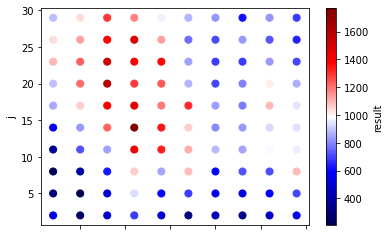

In [ ]:
dt = None
dt = pd.DataFrame(columns = ['i','j', 'result'])
count=0

def buyCondition(row):
  if row['HISTO_KAMA'] > 0 and row['STOCH_RSI'] < 0.82 :
    return True
  else:
    return False

  
def sellCondition(row):
  if row['HISTO_KAMA'] < 0 and row['STOCH_RSI'] > 0.2:
    return True
  else:
    return False

for i in range(2,30,3):
  df['KAMA1'] = ta.momentum.kama(close=ta.momentum.kama(close=ta.momentum.kama(close=df['close'], window=i, pow1=2, pow2=30), window=i, pow1=2, pow2=30), window=i, pow1=2, pow2=30)
  for j in range(2,30,3):
    df['PC_KAMA'] =  df["KAMA1"].pct_change()*100
    df['SMA_KAMA'] = ta.trend.sma_indicator(close=df['PC_KAMA'], window=j)
    df['HISTO_KAMA'] = df['PC_KAMA'] - df['SMA_KAMA']

    ST_length = 10
    ST_multiplier = float(i)
    superTrend = pda.supertrend(high=df['high'], low=df['low'], close=df['close'], length=ST_length, multiplier=ST_multiplier)
    df['SUPER_TREND'] = superTrend['SUPERT_'+str(ST_length)+"_"+str(ST_multiplier)] #Valeur de la super trend
    df['SUPER_TREND_DIRECTION'] = superTrend['SUPERTd_'+str(ST_length)+"_"+str(ST_multiplier)] #Retourne 1 si vert et -1 si rouge
    usdt = 1000
    coin = 0
    fee = 0.0007
    wallet = 1000
    makerFee = 0.0003
    takerFee = 0.0007
    stopLoss = 0
    takeProfit = 500000
    buyReady = True
    sellReady = True

    for index, row in df.iterrows():
        #BUY
        if buyCondition(row) == True and usdt > 0  and buyReady == True:
          buyPrice = row['close']

          # stopLoss = buyPrice - 2 * row['ATR']
          
          coin = usdt/buyPrice
          coin = coin - takerFee*coin
          usdt = 0
          wallet = coin * row['close']
          # print("buy COIN at ",df['close'][index]," || ",index, " || I have ",usdt,"$ and ",coin," coin")

        #Stop Loss
        elif row['low'] < stopLoss and coin > 0:
          sellPrice = stopLoss
          usdt = coin*sellPrice
          usdt = usdt - makerFee*usdt
          coin = 0
          buyReady = False
          wallet = usdt
          # print("Sell COIN at Stop Loss",sellPrice,'$ the', index)


        #SELL
        elif sellCondition(row) == True:
          buyReady = True
          if coin > 0 and sellReady == True:
            sellPrice = row['close']
            usdt = coin*sellPrice
            usdt = usdt - takerFee*usdt
            coin = 0
            wallet = usdt
            # print("sell COIN at ",df['close'][index]," || ",index, "|| I have ",usdt,"$ and ",coin," coin")
    myrow = {'i': i, 'j': j,'result': wallet}
    dt = dt.append(myrow,ignore_index=True) 
print(dt.sort_values(by=['result']))
dt.plot.scatter(x='i',y='j',c='result',s=50,colormap='seismic') 
# dt.plot.scatter(x='i',y=1,c='result',s=50,colormap='rainbow') 
plt.show()

<h1>Future BackTest</h1>

In [ ]:
Comming Soon....